In [1]:
import pennylane as qml

import numpy as np

from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'pennylane'

In [2]:
dev = qml.device("default.qubit", wires=2)

In [3]:
# Pauli matrices
Id = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

parameters = np.loadtxt("HamiltonianParameters.txt")

R = 90
H_param = parameters[parameters[:,0]==R,1:].flatten()

C = H_param[0]
Jx = H_param[1]
Jz = H_param[2]
#Jx = H_param[3]
Jxx = H_param[4]
Jxz = H_param[5]
#Jz = H_param[6]
#Jzx = H_param[7]
Jzz = H_param[8]

print(f"Jx={Jx}, Jz={Jz}, Jxx={Jxx}, Jzz={Jzz}, Jxz={Jxz}, C={C}")

def Hamiltonian():
    H = Jx * (np.kron(X,Id) + np.kron(Id,X))
    H = H + Jz * (np.kron(Z,Id) + np.kron(Id,Z))
    H = H + Jxx * np.kron(X,X)
    H = H + Jzz * np.kron(Z,Z)
    H = H + Jxz * (np.kron(X,Z) + np.kron(Z,X))
    H = H + C * np.kron(Id,Id)

    return H/2

def exactEnergy():
    H = Hamiltonian()

    E, V = np.linalg.eigh(H)
    return np.min(E)

print(f"Exact ground state energy is E = {exactEnergy()}")

Jx=-0.2288, Jz=-1.0466, Jxx=0.2613, Jzz=0.2356, Jxz=0.2288, C=-3.8505
Exact ground state energy is E = -2.8626207640766816


In [4]:
def H_operator():
    H = Jx/2 * (qml.PauliX(0) + qml.PauliX(1))
    H = H + Jz/2 * (qml.PauliZ(0) + qml.PauliZ(1))
    H = H + Jxx/2 * qml.PauliX(0) @ qml.PauliX(1)
    H = H + Jzz/2 * qml.PauliZ(0) @ qml.PauliZ(1)
    H = H + Jxz/2 * (qml.PauliX(0) @ qml.PauliZ(1) + qml.PauliZ(0) @ qml.PauliX(1))
    H = H + C/2 * qml.Identity(0)

    return H

H_qml = qml.matrix(H_operator())

E, _ = np.linalg.eigh(H_qml)
print(f"Exact ground state energy is E = {np.min(E)}")


Exact ground state energy is E = -2.8626207640766816


In [5]:
@qml.qnode(dev)
def ansatz(angles):
    theta = angles[:8]

    # inital rotations
    qml.RX(theta[0], wires=0)
    qml.RZ(theta[1], wires=0)
    qml.RX(theta[2], wires=1)
    qml.RZ(theta[3], wires=1)

    # CNOT to entangle
    qml.CZ(wires=[0,1])

    # second round of rotations
    qml.RX(theta[4], wires=0)
    qml.RZ(theta[5], wires=0)
    qml.RX(theta[6], wires=1)
    qml.RZ(theta[7], wires=1)

    # return all of the expectation values that are needed to compute the energy
    return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliX(1)), qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliX(0) @ qml.PauliX(1)), qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)), qml.expval(qml.PauliX(0) @ qml.PauliZ(1)), qml.expval(qml.PauliZ(0) @ qml.PauliX(1))

In [6]:
def energy_from_circuit(terms):
    # compute the energy from the expectation values
    E = 0
    E = E + Jx/2 * (terms[0] + terms[1])
    E = E + Jz/2 * (terms[2] + terms[3])
    E = E + Jxx/2 * terms[4]
    E = E + Jzz/2 * terms[5]
    E = E + Jxz/2 * (terms[6] + terms[7])
    E = E + C/2
    return E

(0.112060546875, -0.329833984375, -0.8097412109375, -0.4995361328125, -0.126953125, 0.658642578125, 0.36044921875, 0.277294921875)
-1.0812322851562501


(<Figure size 800x300 with 1 Axes>, <Axes: >)

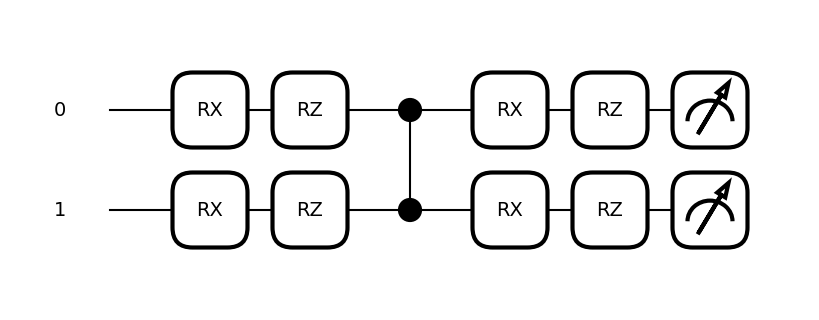

In [7]:
theta = list(2*np.pi*np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]))
angles = theta
test_circuit = ansatz(angles, shots=81920)
print(test_circuit)
print(energy_from_circuit(test_circuit))

qml.drawer.use_style("black_white")
qml.draw_mpl(ansatz)(angles)  # plot the circuit diagram

In [8]:
# compute the energy of the ansatz circuit for given parameters as a test
shots = 81920
theta = list(2*np.pi*np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]))

expvals = ansatz(theta, shots=shots)
E_0 = energy_from_circuit(expvals)

print(f"My energy is E = {E_0}")

print(f"The correct energy (for these parameters) is E = -1.083 ± 0.012 (margin due to finite number of shots)")


My energy is E = -1.0859016491699218
The correct energy (for these parameters) is E = -1.083 ± 0.012 (margin due to finite number of shots)


In [9]:
theta = 2*np.pi*np.random.rand(8)  # random initial angle values!
c = 0.05*2*np.pi  # c used in approximating the gradient
eta = 0.5  # controls the rate of descent
shots = 8192

energy_list = []

iterations = 25

for jj in range(iterations):

    angles = [[]]*8
    basis = [[]]*2
    gradient = []
    for ii in range(8):
        e = np.zeros(8)
        e[ii] = 1
        theta_plus = theta.copy() + c*e
        theta_minus = theta.copy() - c*e

        angles = [angles[kk] + [theta_plus[kk]] for kk in range(8)]
        angles = [angles[kk] + [theta_minus[kk]] for kk in range(8)]

    angles = [angles[kk] + [theta[kk]] for kk in range(8)]

    expvals = ansatz(angles, shots=shots)
    expvals = np.array(expvals)

    for ii in range(8):
        E_plus = energy_from_circuit(expvals[:, 2*ii])
        E_minus = energy_from_circuit(expvals[:, 2*ii+1])

        gradient.append( (E_plus - E_minus)/(2*c) )  # approximate gradient

    energy_list.append(energy_from_circuit(expvals[:,-1]))

    theta = theta - eta*np.array(gradient)  # update the angles using gradient descent!

    print(f"Energy at iteration {jj}: {energy_list[-1]}")

angles = [[theta[kk]] for kk in range(8)]

expvals = ansatz(angles, shots=shots)
E_final = energy_from_circuit(expvals)
energy_list.append( E_final )  # final energy!

print(f"Final energy: {energy_list[-1]}")

print(energy_list)

Energy at iteration 0: -2.1409552490234374
Energy at iteration 1: -2.173428576660156
Energy at iteration 2: -2.2064468627929688
Energy at iteration 3: -2.2368505615234375
Energy at iteration 4: -2.290246533203125
Energy at iteration 5: -2.3307554931640624
Energy at iteration 6: -2.38229873046875
Energy at iteration 7: -2.456269445800781
Energy at iteration 8: -2.531744738769531
Energy at iteration 9: -2.5841414306640624
Energy at iteration 10: -2.6515321289062497
Energy at iteration 11: -2.6947919189453122
Energy at iteration 12: -2.724547265625
Energy at iteration 13: -2.7644747436523436
Energy at iteration 14: -2.7888011474609375
Energy at iteration 15: -2.8109153808593748
Energy at iteration 16: -2.822694873046875
Energy at iteration 17: -2.822788818359375
Energy at iteration 18: -2.8347963134765624
Energy at iteration 19: -2.837775048828125
Energy at iteration 20: -2.843021423339844
Energy at iteration 21: -2.8474131958007813
Energy at iteration 22: -2.8523161865234377
Energy at it

angles: [2.6601473  0.48368376 5.96525672 3.06615795 3.65331775 4.94687813
 0.31095815 5.21916105]


Text(0.5, 0, 'iteration')

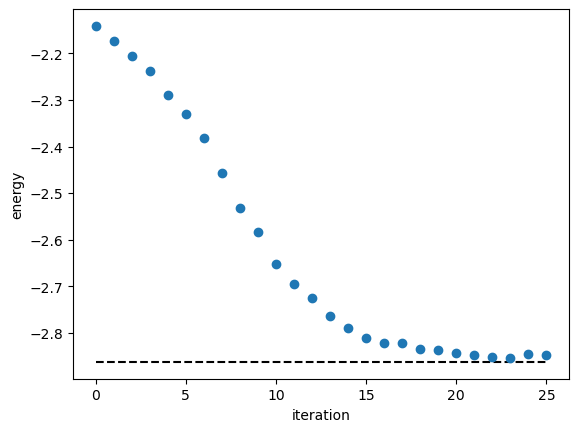

In [10]:
print(f"angles: {theta}")
# plot the results!
plt.plot([0,iterations],[exactEnergy(),exactEnergy()],'--',color='k')
plt.plot(energy_list,'o')
plt.ylabel('energy')
plt.xlabel('iteration')